In [130]:
import itertools

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import power_transform
import warnings

warnings.filterwarnings('ignore')

### EDA

In [131]:
df = pd.read_csv('Sleep_Efficiency.csv')
# Dropping records with nulls
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      388 non-null    int64  
 1   Age                     388 non-null    int64  
 2   Gender                  388 non-null    object 
 3   Bedtime                 388 non-null    object 
 4   Wakeup time             388 non-null    object 
 5   Sleep duration          388 non-null    float64
 6   Sleep efficiency        388 non-null    float64
 7   REM sleep percentage    388 non-null    int64  
 8   Deep sleep percentage   388 non-null    int64  
 9   Light sleep percentage  388 non-null    int64  
 10  Awakenings              388 non-null    float64
 11  Caffeine consumption    388 non-null    float64
 12  Alcohol consumption     388 non-null    float64
 13  Smoking status          388 non-null    object 
 14  Exercise frequency      388 non-null    fl

In [132]:
# Converting time columns to dattime datatype
df['Bedtime'] = df['Bedtime'].astype('datetime64[ns]')
df['Wakeup time'] = df['Wakeup time'].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      388 non-null    int64         
 1   Age                     388 non-null    int64         
 2   Gender                  388 non-null    object        
 3   Bedtime                 388 non-null    datetime64[ns]
 4   Wakeup time             388 non-null    datetime64[ns]
 5   Sleep duration          388 non-null    float64       
 6   Sleep efficiency        388 non-null    float64       
 7   REM sleep percentage    388 non-null    int64         
 8   Deep sleep percentage   388 non-null    int64         
 9   Light sleep percentage  388 non-null    int64         
 10  Awakenings              388 non-null    float64       
 11  Caffeine consumption    388 non-null    float64       
 12  Alcohol consumption     388 non-null    float64   

In [133]:
# Making dummies for categorical columns Gender and Smoking
# df_new = pd.get_dummies(df,drop_first=True,dtype=int)
# df_new.head()

In [134]:
# Making column names easier to utilise
# replacing spaces with '_' and making column names lowercase
df.columns = df.columns.str.replace(' ','_').str.lower()

# Dropping target and predictors that doesn't make sense to include in regression
X = df.drop(['sleep_efficiency','wakeup_time','bedtime','id'],axis=1)
Y = df['sleep_efficiency']

### Multicollinearity

In [135]:
# VIF calculation function
def calc_vif(colnames,df):
    vif =  pd.DataFrame()
    cols = sm.add_constant(df[colnames])
    vif['VIF'] = [variance_inflation_factor(cols.values,i) for i in range(cols.shape[1])]
    vif['Features'] = cols.keys()
    return vif

In [136]:
# VIF of numeric for base model
num_cols = list(X.select_dtypes('number').columns)
calc_vif(num_cols,df)

,VIF,Features
0,0.000000,const
1,1.048238,age
2,1.014314,sleep_duration
3,inf,rem_sleep_percentage
4,inf,deep_sleep_percentage
5,inf,light_sleep_percentage
6,1.203208,awakenings
7,1.078431,caffeine_consumption
8,1.224158,alcohol_consumption
9,1.099671,exercise_frequency


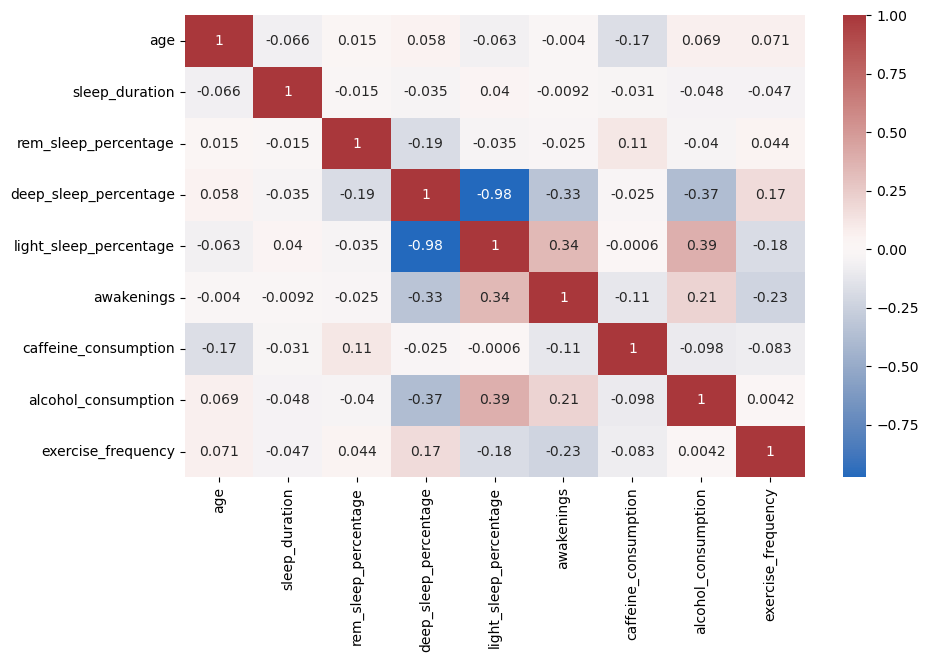

In [137]:
# Cross checking VIF of inf with heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,cmap='vlag')
plt.show()

In [138]:
# Choosing to combine deep and light sleep percentages into a deep/light ratio
X['deep_light_sleep_ratio'] = X['light_sleep_percentage'] #- X['deep_sleep_percentage']
X2 = X.drop(['deep_sleep_percentage','light_sleep_percentage'],axis=1,errors='ignore')
num_cols = list(X2.select_dtypes('number').columns)

# Recalculating VIF
calc_vif(num_cols,X2)

,VIF,Features
0,138.279166,const
1,1.048238,age
2,1.014314,sleep_duration
3,1.018516,rem_sleep_percentage
4,1.203208,awakenings
5,1.078431,caffeine_consumption
6,1.224158,alcohol_consumption
7,1.099671,exercise_frequency
8,1.328048,deep_light_sleep_ratio


### Model Building

In [139]:
# Making model formula
pred = X2.columns
formula = 'sleep_efficiency ~ ' + ' + '.join(pred)
df_new = X2.copy()
df_new['sleep_efficiency'] = Y #power_transform(np.array(Y).reshape(-1, 1))
# Creating base model w/ summary
model = smf.ols(formula,df_new).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       sleep_efficiency   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     155.7
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          3.28e-127
Time:                        14:40:05   Log-Likelihood:                 542.09
No. Observations:                 388   AIC:                            -1062.
Df Residuals:                     377   BIC:                            -1019.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.9056      0.036     24.887      0.000       0.834       0.977
gender[T.Male]             0.0014      0.007      0.207      0.836      -0.012       0.015
smoking_status[T.Yes]     -0.0460      0.007     -6.780      0.000      -0.059      -0.033
age                        0.0010      0.000      3.920      0.000       0.000       0.001
sleep_duration             0.0017      0.004      0.497      0.620      -0.005       0.009
rem_sleep_percentage       0.0011      0.001      1.209      0.227      -0.001       0.003
awakenings                -0.0319      0.003    -12.626      0.000      -0.037      -0.027
caffeine_consumption       0.0002      0.000      2.132      0.034    1.87e-05       0.000
alcohol_consumption       -0.0061      0.002     -2.895      0.004      -0.010      -0.002
exercise_frequency         0.0064      0.002      2.783      0.006       0.002       0.011
deep_light_sleep_ratio    -0.0056      0.000    -23.425      0.000      -0.006      -0.005
==============================================================================
Omnibus:                        8.616   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.678
Skew:                          -0.340   Prob(JB):                       0.0131
Kurtosis:                       2.726   Cond. No.                         710.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Diagnostics

#### Model Assumption Violation Detection

In [140]:
# Residual Normality
print('Omnibus P_value:',model.summary().tables[2][1][1])
print('JB P_value:',model.summary().tables[2][2][3])
# Not violated

Omnibus P_value:  0.013
JB P_value:   0.0131


In [141]:
# Autocorrelation / Independance of residuals
print('Durbin-Watson Statistic:',model.summary().tables[2][0][3])
# The Durbin Watson Stat is close to 2, meaning that autocorrelation is not present in the target and residuals

Durbin-Watson Statistic:    1.985


12.725095390376632 0.23945075736463792


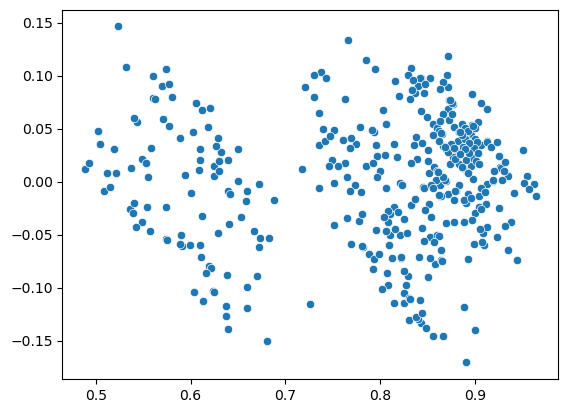

In [142]:
# Test for Constant Variance in Residuals (breusch-pagan)
lm_stat, lm_p, fstat,f_p = sms.het_breuschpagan(model.resid,model.model.exog)
print(lm_stat,lm_p)
# Residual plot
sns.scatterplot(x=model.fittedvalues,y=model.resid)
plt.show()

# Breusch Pagan test has a p-value > 0.05, indicating  no significant non-constant variance among residuals
# Residual plot does not indicate any clear changing of variance

#### Outlier detection and handling

In [143]:
# Function to get outliers that have significant external studentized residuals as well as Cook's distances
def outlier_metrics(df_new,model):
    p = model.model.exog.shape[1]
    n= model.model.exog.shape[0]
    infl = model.get_influence()

    seuil_stud = stats.t.ppf(0.975,df=n-p-1)
    #detection - absolute value > threshold
    reg_studs=infl.resid_studentized_external
    atyp_stud = np.abs(reg_studs) > seuil_stud

    ext_res = pd.DataFrame([df_new.index[atyp_stud],reg_studs[atyp_stud]],index=['Index','ext_stud_resid']).T
    ext_res['Index'] = ext_res['Index'].astype(int)

    inflsum=infl.summary_frame()
    reg_cook=inflsum.cooks_d
    atyp_cook = np.abs(reg_cook) >= 4/n
    cooks = pd.DataFrame([df_new.index[atyp_cook],reg_cook[atyp_cook]],index=['Index','cooks']).T
    cooks['Index'] = cooks['Index'].astype(int)

    return pd.merge(ext_res,cooks,on='Index')

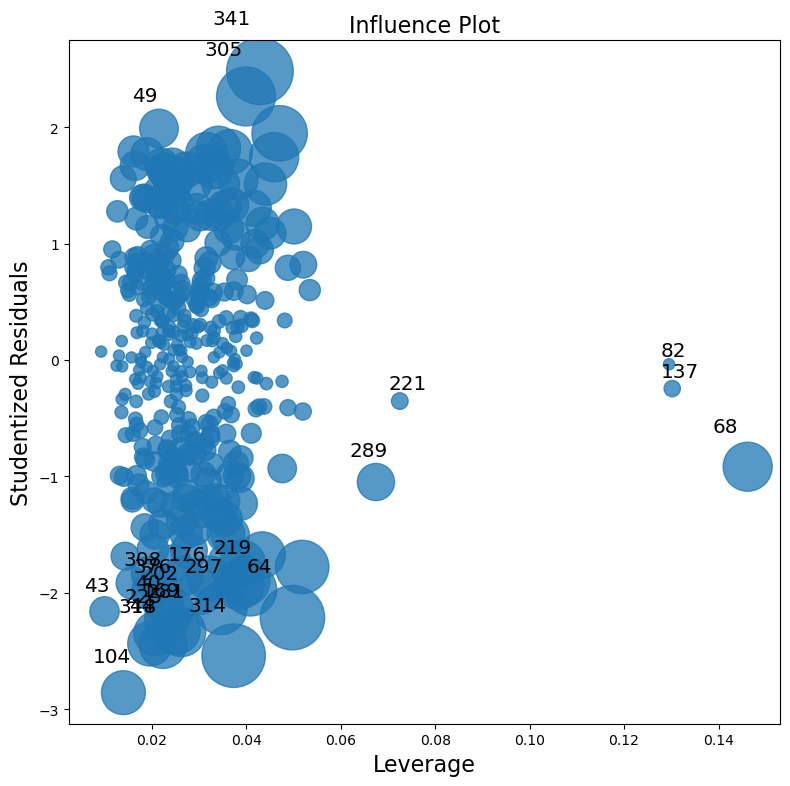

In [144]:
# Influence plot with observations of high Cook's Distance being annotated
fig, ax = plt.subplots(figsize=(8,8))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks")
plt.tight_layout()

In [145]:
# List of outliers and their indexes in the original data
outliers = outlier_metrics(df_new, model)
outliers.sort_values('cooks')

,Index,ext_stud_resid,cooks
3,104,-2.858062,0.010353
7,225,-2.349168,0.010582
0,40,-2.229071,0.010601
12,318,-2.437604,0.010686
5,176,-1.991670,0.011169
1,44,-2.445385,0.012294
4,169,-2.324050,0.012541
8,281,-2.337128,0.013225
9,297,-2.136155,0.014760
6,219,-1.974220,0.015005


In [146]:
# Outlier Removal
df_final = df_new.drop(outliers['Index'])

### Model Selection

#### Best Subsets

In [147]:
def best_subsets(df,target):
    predictors = df.columns.drop(target)
    full_formula = f'{target} ~ ' + ' + '.join(predictors)
    full_model = smf.ols(full_formula,df).fit()

    subset_reg = pd.DataFrame(columns=['R2','Adj_R2','k','Mallows Cp', 'AIC', 'BIC'])
    subset_reg.index.name = 'Predictors'
    for i in range(1,len(predictors)+1):
        for c in combinations(predictors,i):
            formula = f'{target} ~ ' + ' + '.join(c)
            model = smf.ols(formula,df).fit()
            Cp = (model.ssr / full_model.mse_resid) - (model.nobs - 2*(i+1))
            subset_reg.loc[','.join(c)] = [model.rsquared,model.rsquared_adj,i+1, Cp, model.aic, model.bic]

    return subset_reg

In [148]:
subsets = best_subsets(df_final, 'sleep_efficiency')

In [149]:
subsets.sort_values('BIC',ascending=True).head(10)

,R2,Adj_R2,k,Mallows Cp,AIC,BIC
Predictors,,,,,,
"age,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.834636,0.831473,8.0,7.986967,-1096.933853,-1065.539806
"age,awakenings,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.830795,0.828029,7.0,14.486625,-1090.347425,-1062.877634
"age,rem_sleep_percentage,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.835591,0.831988,9.0,7.872351,-1097.101034,-1061.782732
"age,rem_sleep_percentage,awakenings,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.832275,0.829067,8.0,13.211737,-1091.632441,-1060.238395
"age,sleep_duration,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.834834,0.831214,9.0,9.547668,-1095.383040,-1060.064737
"age,gender,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.834735,0.831113,9.0,9.767412,-1095.158282,-1059.839980
"age,sleep_duration,awakenings,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.830913,0.827679,8.0,16.226485,-1088.607316,-1057.213270
"age,gender,awakenings,alcohol_consumption,smoking_status,exercise_frequency,deep_light_sleep_ratio",0.830808,0.827573,8.0,16.457363,-1088.376650,-1056.982604
"age,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,deep_light_sleep_ratio",0.828059,0.825248,7.0,20.543282,-1084.347031,-1056.877241


#### Forward Stepwise

In [150]:
def forward_stepwise(df,target):
    predictors = df.columns.drop(target)
    full_formula = f'{target} ~ ' + ' + '.join(predictors)
    full_model = smf.ols(full_formula,df).fit()

    remaining_features = list(predictors)
    features = []
    k = len(predictors)
    f_stepwise_reg = pd.DataFrame(columns=['RSS','R2','Adj_R2','k','Cp', 'AIC', 'BIC'])
    f_stepwise_reg.index.name = 'Predictors'

    for i in range(1,k+1):
        best_RSS = np.inf
        for c in itertools.combinations(remaining_features,1):

                formula = f'{target} ~ ' + ' + '.join(list(c)+features)
                model = smf.ols(formula,df_new).fit()
                if model.ssr < best_RSS:
                    best_model = model
                    best_RSS = model.ssr
                    
                    best_feature = c[0]

        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)
        
        # Updating dataframe with model metrics
        Cp = (best_model.ssr / full_model.mse_resid) - (model.nobs - 2*(k+1))
        f_stepwise_reg.loc[','.join(features)] = [best_RSS,best_model.rsquared,best_model.rsquared_adj,i+1,Cp, best_model.aic, best_model.bic]

    return f_stepwise_reg.reset_index()

In [172]:
stepwise = forward_stepwise(df_final, 'sleep_efficiency')
from tabulate import tabulate
table = tabulate(
    stepwise,
    headers='keys',
    tablefmt='fancy_grid',
    showindex=False,
    floatfmt='g',
    numalign='center',
    stralign='left',
    disable_numparse=True,
    maxcolwidths=[40]
)
print(table)

╒══════════════════════════════════════════╤════════════════════╤════════════════════╤════════════════════╤══════╤════════════════════╤═════════════════════╤═════════════════════╕
│ Predictors                               │ RSS                │ R2                 │ Adj_R2             │ k    │ Cp                 │ AIC                 │ BIC                 │
╞══════════════════════════════════════════╪════════════════════╪════════════════════╪════════════════════╪══════╪════════════════════╪═════════════════════╪═════════════════════╡
│ deep_light_sleep_ratio                   │ 2.370599754789944  │ 0.6673814978031569 │ 0.6665197918389164 │ 2.0  │ 410.7518591796819  │ -872.8742921275937  │ -864.9522814483471  │
├──────────────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────┼────────────────────┼─────────────────────┼─────────────────────┤
│ deep_light_sleep_ratio,awakenings        │ 1.686974033686564  │ 0.7633009219730087 │ 0.76207131637

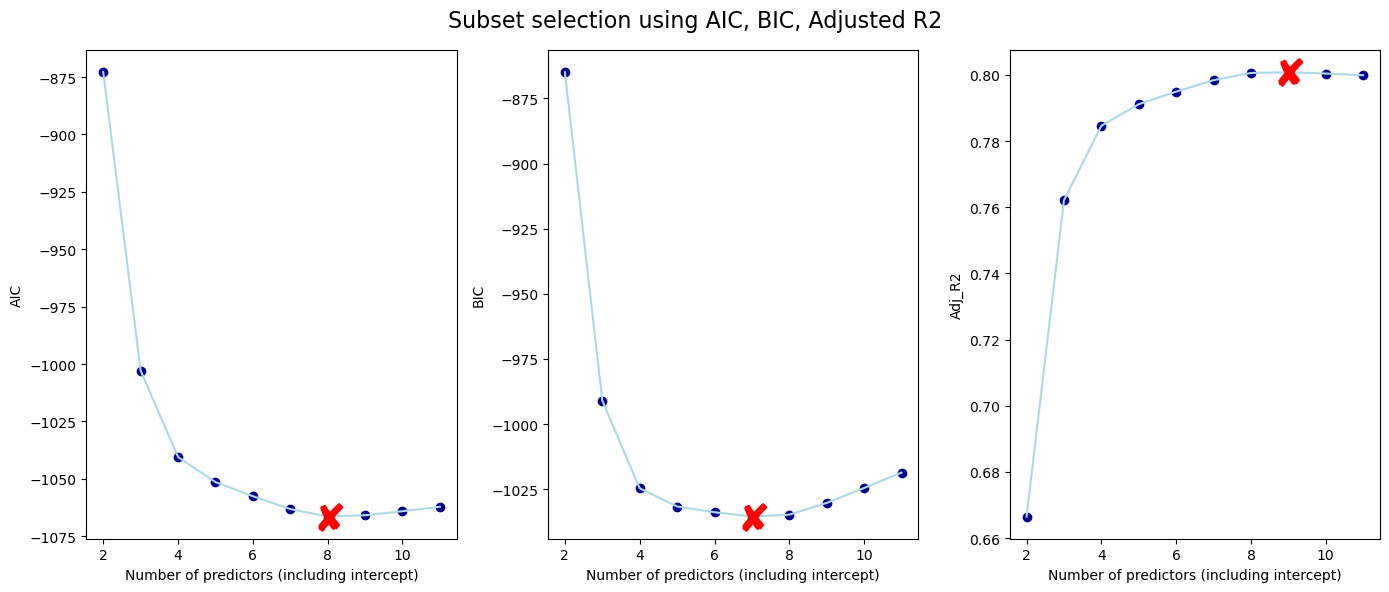

In [152]:
variables = ['AIC','BIC','Adj_R2']
fig = plt.figure(figsize = (14,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(stepwise['k'],stepwise[v], color = 'lightblue')
    ax.scatter(stepwise['k'],stepwise[v], color = 'darkblue')
    if v == 'Adj_R2':
        ax.plot(stepwise[v].idxmax()+2,stepwise[v].max(), marker = '$✘$', markersize = 20, color='red')
    else:
        ax.plot(stepwise[v].idxmin()+2,stepwise[v].min(), marker = '$✘$', markersize = 20, color='red')
    ax.set_xlabel('Number of predictors (including intercept)')
    ax.set_ylabel(v)
fig.suptitle('Subset selection using AIC, BIC, Adjusted R2', fontsize = 16)
plt.tight_layout()
plt.show()  